In [103]:
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import wfdb

FOLDER_PATH = '24h-emgcg/'

In [ ]:
# READ NUMBER OF RECORD EACH 
record_files = [f for f in os.listdir(FOLDER_PATH) if f.endswith('.hea')]
records_samples = []

for record_file in record_files:
    record_name = os.path.splitext(record_file)[0]
    record_header = wfdb.rdheader(os.path.join(FOLDER_PATH, record_name))
    num_samples = record_header.sig_len
    records_samples.append([record_name, num_samples])

# Now records_samples contains a list of [record_name, num_samples] for each record
for record, samples in records_samples:
    print(f"Record '{record}' has {samples} samples.")

Record 's0218-05110112' has 30260496 samples.
Record 's0194-05071409' has 39549486 samples.
Record 's0064-05081806' has 57574788 samples.
Record 's0321-07022204' has 21912 samples.
Record 's0067-05040511' has 49570746 samples.
Record 's0132-04102802' has 46897408 samples.
Record 's0242-06012407' has 37140432 samples.
Record 's0030-04051908' has 55066318 samples.
Record 's0067-05040510' has 8035950 samples.
Record 's0321-07022205' has 27890484 samples.
Record 's0194-05071408' has 43629450 samples.
Record 's0221-06082201' has 16404 samples.
Record 's0218-05110113' has 51666246 samples.
Record 's0221-06082203' has 6888 samples.
Record 's0064-05081805' has 25282776 samples.
Record 's0172-05071906' has 40709484 samples.
Record 's0132-04102801' has 26168545 samples.
Record 's0243-06031609' has 33042288 samples.
Record 's0232-06060108' has 26105460 samples.
Record 's0242-06012405' has 45681954 samples.
Record 's0244-06041304' has 54407868 samples.
Record 's0321-07022206' has 55360422 samples.

In [104]:
# DELETE ALL .dat .hea .maker files
 
# Define file extensions to delete
extensions_to_delete = ['.dat', '.hea', '.marker']

# Function to delete files with given extensions
def delete_files_with_extensions(FOLDER_PATH, extensions):
    for ext in extensions:
        file_pattern = os.path.join(FOLDER_PATH, f'*{ext}')
        files = glob.glob(file_pattern)
        for file in files:
            try:
                os.remove(file)
                print(f"Deleted: {file}")
            except OSError as e:
                print(f"Error: {file} - {e.strerror}")

# Delete files
delete_files_with_extensions(FOLDER_PATH, extensions_to_delete)

In [105]:
# CONVERT TO p_signal FILES USING 2 CHANNEL ecg_0 vs ecg_1

# List all .hea files in the folder
record_files = [f for f in os.listdir(FOLDER_PATH) if f.endswith('.hea')]

# Initialize an array to hold the names of records missing .dat files
records_missing_dat = []

records_exist = []

for record_file in record_files:
    # Extract the base name of the record (without extension)
    record_name = os.path.splitext(record_file)[0]
    
    # Check if the corresponding .dat file exists
    if not os.path.exists(os.path.join(FOLDER_PATH, f"{record_name}.dat")):
        records_missing_dat.append(record_name)
        continue  # Skip to the next record
    
    # Define the path for the output .p_signal file
    output_file_path = os.path.join(FOLDER_PATH, f"{record_name}_p_signal.txt")
    
    # Check if the .p_signal file already exists
    if os.path.exists(output_file_path):
        records_exist.append(record_file)
        continue  # Skip to the next record if .p_signal file exists
    
    # Read the specified channels (0 and 1) from the record
    try:
        record = wfdb.rdrecord(os.path.join(FOLDER_PATH, record_name), channels=[0, 1])
    except FileNotFoundError:
        # This block catches the case where the .hea file exists without its .dat file,
        # although this should be primarily handled by the earlier .dat check
        records_missing_dat.append(record_name)
        continue
    
    # Extract the signals for channels 0 and 1
    signals = record.p_signal
    
    # Write the signals to the output file
    with open(output_file_path, 'w') as file:
        for signal in signals:
            file.write(f"{signal[0]}\t{signal[1]}\n")

# Output the records that were skipped due to missing .dat files
print("Conversion completed. The following records were skipped due to missing .dat files:")
print(records_missing_dat)

print("amount built: ")
print(len(records_exist))

Conversion completed. The following records were skipped due to missing .dat files:
[]
amount built: 
0


In [75]:
# CONVERT BY CALL PHYSIONET

# Define the PhysioNet directory for the dataset
pn_dir = 'cves'
pn_dir_full = 'cves/1.0.0/data/24h-electromyography'

# Ensure the local save directory exists
os.makedirs(FOLDER_PATH, exist_ok=True)

# Get the list of records from the specified PhysioNet directory
record_names = wfdb.get_record_list(pn_dir)

# Get list of ecg-emg record from the list above by cut off the prefix
record_ecgmg = [record.split('/')[2] for record in record_names if record.startswith("data/24h-electromyography/")]

for record_name in record_ecgmg:
    # Define the path for the expected .p_signal output file
    output_file_path = os.path.join(FOLDER_PATH, f"{record_name}_p_signal.txt")
    
    # Check if the .p_signal file already exists
    if os.path.exists(output_file_path):
        print(f"File {output_file_path} already exists. Skipping...")
        continue

    # Read the specified channels (0 and 1) from the record directly from PhysioNet
    # Note: This step requires an internet connection and access permissions to the data
    record = wfdb.rdrecord(record_name, pn_dir=pn_dir_full, channels=[0, 1])

    # Extract the signals for channels 0 and 1
    signals = record.p_signal

    # Write the signals to the output file
    with open(output_file_path, 'w') as file:
        for signal in signals:
            # Write each signal sample to the file, separated by a tab
            file.write(f"{signal[0]}\t{signal[1]}\n")

print("Conversion completed. Check the local directory for the .p_signal files.")


File 24h-emgcg/s0030-04051907_p_signal.txt already exists. Skipping...
File 24h-emgcg/s0030-04051908_p_signal.txt already exists. Skipping...
File 24h-emgcg/s0044-05062806_p_signal.txt already exists. Skipping...
File 24h-emgcg/s0044-05062807_p_signal.txt already exists. Skipping...
File 24h-emgcg/s0064-05081805_p_signal.txt already exists. Skipping...
File 24h-emgcg/s0064-05081806_p_signal.txt already exists. Skipping...
File 24h-emgcg/s0067-05040508_p_signal.txt already exists. Skipping...
File 24h-emgcg/s0067-05040509_p_signal.txt already exists. Skipping...
File 24h-emgcg/s0067-05040510_p_signal.txt already exists. Skipping...
File 24h-emgcg/s0067-05040511_p_signal.txt already exists. Skipping...
File 24h-emgcg/s0068-05022417_p_signal.txt already exists. Skipping...
File 24h-emgcg/s0068-05022418_p_signal.txt already exists. Skipping...
File 24h-emgcg/s0121-04042801_p_signal.txt already exists. Skipping...
File 24h-emgcg/s0121-04042802_p_signal.txt already exists. Skipping...
File 2

ValueError: string size must be a multiple of element size

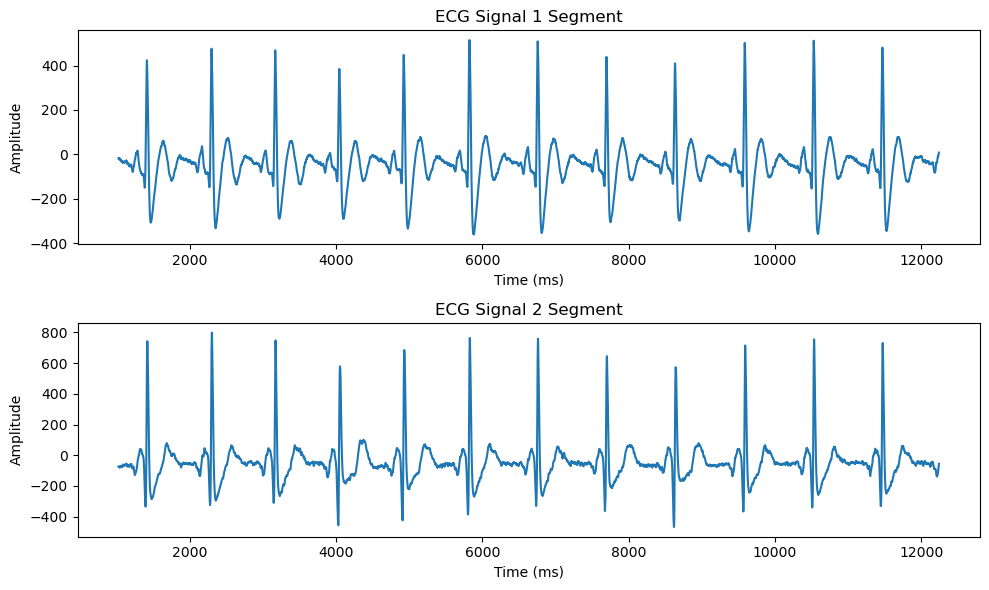

In [106]:
# GET LIST OF PREFIX TXT NAME
def get_main_names_of_files(FOLDER_PATH):
    file_names = os.listdir(FOLDER_PATH)
    main_names = [name.split('_p_signal.txt')[0] for name in file_names if name.endswith('_p_signal.txt')]
    return main_names

# PLOT SIGNAL IN RANGE(m , n) BY FILENAME
def plot_ecg_signal(main_name_of_file, n, m=0):
    # start m end n
    file_path = os.path.join(FOLDER_PATH, f'{main_name_of_file}_p_signal.txt')
    
    if not os.path.exists(file_path):
        print(f'File {file_path} does not exist.')
        return
    
    try:
        # Load the data with a maximum of 'n' rows
        total_data = np.loadtxt(file_path, max_rows=n)
        total_rows = total_data.shape[0]
        
        if m < 0 or n > total_rows or m >= n:
            raise ValueError(f"Invalid range: {m} to {n}. File contains {total_rows} rows.")
        
        # Since numpy.loadtxt doesn't support loading a slice directly, we use slicing after loading
        data_segment = total_data[m:n, :]
        
    except Exception as e:
        print(f"Error reading the file: {e}")
        return
    
    # Time array for the segment
    time = np.arange(m, n) * 1  # 1 ms per sample
    
    # Plotting
    plt.figure(figsize=(10, 6))
    
    plt.subplot(2, 1, 1)
    plt.plot(time, data_segment[:, 0])
    plt.title('ECG Signal 1 Segment')
    plt.xlabel('Time (ms)')
    plt.ylabel('Amplitude')
    
    plt.subplot(2, 1, 2)
    plt.plot(time, data_segment[:, 1])
    plt.title('ECG Signal 2 Segment')
    plt.xlabel('Time (ms)')
    plt.ylabel('Amplitude')
    
    plt.tight_layout()
    plt.show()

# Example usage
names = get_main_names_of_files(FOLDER_PATH)
# print("Main names of files:", names)

plot_ecg_signal(names[1], 12245, 1023)
